In [1]:
reInstaller = True

if reInstaller:
  #!git clone https://github.com/TheoGachet/point-transformer
  import os
  os.system("pip install torch==1.9.0+cu111 torch-scatter torch-sparse torch-cluster torch-spline-conv torch-geometric numpy scipy tqdm matplotlib git")
  if not os.path.isdir("point-transformer"):
      os.system("https://github.com/TheoGachet/point-transformer")
  print("✅ Dépendances installées et repo cloné")

✅ Dépendances installées et repo cloné


In [8]:
!pip install torch torch-scatter torch-sparse torch-cluster torch-spline-conv torch-geometric numpy scipy tqdm matplotlib git

  Using cached torch-2.7.1-cp313-cp313-win_amd64.whl.metadata (28 kB)
  Using cached torch_scatter-2.1.2.tar.gz (108 kB)
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'error'


  error: subprocess-exited-with-error
  
  × Getting requirements to build wheel did not run successfully.
  │ exit code: 1
  ╰─> [23 lines of output]
      Traceback (most recent call last):
        File "C:\Users\theog\Nouveau dossier\Polytechnique\Research\research-code\point-transformer\point_env\Lib\site-packages\pip\_vendor\pyproject_hooks\_in_process\_in_process.py", line 389, in <module>
          main()
          ~~~~^^
        File "C:\Users\theog\Nouveau dossier\Polytechnique\Research\research-code\point-transformer\point_env\Lib\site-packages\pip\_vendor\pyproject_hooks\_in_process\_in_process.py", line 373, in main
          json_out["return_val"] = hook(**hook_input["kwargs"])
                                   ~~~~^^^^^^^^^^^^^^^^^^^^^^^^
        File "C:\Users\theog\Nouveau dossier\Polytechnique\Research\research-code\point-transformer\point_env\Lib\site-packages\pip\_vendor\pyproject_hooks\_in_process\_in_process.py", line 143, in get_requires_for_build_wheel
         

In [3]:
os.chdir("lib/pointops")
os.system("python setup.py build install")
os.chdir("../..")
print("✅ Extensions CUDA compilées")

✅ Extensions CUDA compilées


In [4]:
import torch

# Formatte la version de torch et CUDA
TORCH = torch.__version__.split('+')[0]
CUDA = 'cu' + torch.version.cuda.replace('.', '')

print("Installing for PyTorch", TORCH, "with CUDA", CUDA)

# Installe les dépendances nécessaires
os_command = (
    f"pip install torch-scatter -f https://data.pyg.org/whl/torch-{TORCH}+{CUDA}.html && "
    f"pip install torch-sparse -f https://data.pyg.org/whl/torch-{TORCH}+{CUDA}.html && "
    f"pip install torch-cluster -f https://data.pyg.org/whl/torch-{TORCH}+{CUDA}.html && "
    f"pip install torch-spline-conv -f https://data.pyg.org/whl/torch-{TORCH}+{CUDA}.html && "
    "pip install torch-geometric"
)

print(os.popen(os_command).read())
print("✅ torch_geometric et dépendances installés")


ModuleNotFoundError: No module named 'torch'

In [1]:
reInstaller = True

if reInstaller:
  #!git clone https://github.com/TheoGachet/point-transformer
  import os
  os.system("pip install torch==1.9.0+cu111 torch-scatter torch-sparse torch-cluster torch-spline-conv torch-geometric numpy scipy tqdm matplotlib git")
  if not os.path.isdir("point-transformer"):
      os.system("https://github.com/TheoGachet/point-transformer")
  print("✅ Dépendances installées et repo cloné")
  os.chdir("point-transformer/lib/pointops")
  os.system("python setup.py build install")
  os.chdir("../..")
  print("✅ Extensions CUDA compilées")
  import torch

  # Formatte la version de torch et CUDA
  TORCH = torch.__version__.split('+')[0]
  CUDA = 'cu' + torch.version.cuda.replace('.', '')

  print("Installing for PyTorch", TORCH, "with CUDA", CUDA)

  # Installe les dépendances nécessaires
  os_command = (
      f"pip install torch-scatter -f https://data.pyg.org/whl/torch-{TORCH}+{CUDA}.html && "
      f"pip install torch-sparse -f https://data.pyg.org/whl/torch-{TORCH}+{CUDA}.html && "
      f"pip install torch-cluster -f https://data.pyg.org/whl/torch-{TORCH}+{CUDA}.html && "
      f"pip install torch-spline-conv -f https://data.pyg.org/whl/torch-{TORCH}+{CUDA}.html && "
      "pip install torch-geometric"
  )

  print(os.popen(os_command).read())
  print("✅ torch_geometric et dépendances installés")


Cloning into 'point-transformer'...
remote: Enumerating objects: 4884, done.
remote: Counting objects: 100% (157/157), done.
remote: Compressing objects: 100% (157/157), done.
remote: Total 4884 (delta 0), reused 155 (delta 0), pack-reused 4727 (from 1)
Receiving objects: 100% (4884/4884), 8.64 GiB | 36.57 MiB/s, done.
Resolving deltas: 100% (32/32), done.
Updating files: 100% (4825/4825), done.
✅ Dépendances installées et repo cloné


---

In [3]:
import os, glob, numpy as np, torch
import torch.nn.functional as F
from torch.utils.data import Dataset
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
from torch_geometric.nn import PointTransformerConv, knn_graph
from torch.nn import Linear
from tqdm.notebook import tqdm  # barre progress en notebook

# 1️⃣ Classe Dataset pour tes fichiers .npz
class LuSNARDataset(Dataset):
    def __init__(self, folder):
        self.paths = sorted(glob.glob(f"{folder}/*.npz"))
        assert self.paths, f"Aucun .npz trouvé dans {folder}"
    def __len__(self): return len(self.paths)
    def __getitem__(self, i):
        d = np.load(self.paths[i], allow_pickle=True)
        pts = torch.from_numpy(d['lidar_points']).float()
        lbl = torch.from_numpy(d['lidar_category']).long()
        mask = lbl != -1
        pts, lbl = pts[mask], lbl[mask]
        unique = lbl.unique(sorted=True)
        mapping = {v.item(): idx for idx, v in enumerate(unique)}
        lbl = torch.tensor([mapping[v.item()] for v in lbl], dtype=torch.long)
        batch = torch.zeros(pts.size(0), dtype=torch.long)
        return Data(pos=pts, y=lbl, batch=batch)

# 2️⃣ Préparer dataset & loader
folder = "/content/point-transformer/data/moon"
dataset = LuSNARDataset(folder)
loader = DataLoader(dataset, batch_size=2, shuffle=True)
all_y = torch.cat([d.y for d in dataset])
num_classes = int(all_y.max().item()) + 1
print(f"✅ {len(dataset)} samples — num_classes = {num_classes}")

✅ 4780 samples — num_classes = 2


In [4]:
# 3️⃣ Définition du modèle Point Transformer
class PTNet(torch.nn.Module):
    def __init__(self, nc):
        super().__init__()
        self.lin_in = Linear(3, 64)
        self.conv1 = PointTransformerConv(64, 64)
        self.conv2 = PointTransformerConv(64, 128)
        self.head = Linear(128, nc)
    def forward(self, data):
        x, pos, batch = data.pos, data.pos, data.batch
        x = F.relu(self.lin_in(x))
        edge_index = knn_graph(pos, k=16, batch=batch)
        x = F.relu(self.conv1(x, pos, edge_index=edge_index))
        x = F.relu(self.conv2(x, pos, edge_index=edge_index))
        return self.head(x)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = PTNet(num_classes).to(device)
opt = torch.optim.Adam(model.parameters(), lr=1e-3)
crit = torch.nn.CrossEntropyLoss()

In [5]:
from torch.utils.data import random_split

train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=2)

In [24]:
# 🔁 Rechargement depuis un checkpoint

checkpoint_path = "checkpoints/epoch_10.pth"  # ⬅️ à adapter selon le fichier

checkpoint = torch.load(checkpoint_path, map_location=device, weights_only=False)

model.load_state_dict(checkpoint["model_state_dict"])
opt.load_state_dict(checkpoint["optimizer_state_dict"])
start_epoch = checkpoint["epoch"] + 1  # pour reprendre à l'epoch suivante

print(f"✅ Modèle rechargé depuis l'epoch {checkpoint['epoch']} — OA: {checkpoint['oa']:.3f}, mIoU: {checkpoint['miou']:.3f}")



✅ Modèle rechargé depuis l'epoch 10 — OA: 0.834, mIoU: 0.513


In [25]:
import os
import torch
from sklearn.metrics import confusion_matrix
from tqdm.notebook import tqdm

CHECKPOINT_DIR = "checkpoints"
os.makedirs(CHECKPOINT_DIR, exist_ok=True)

#start_epoch = 1
num_epochs = 100
best_miou = 0.0
patience = 10
epochs_without_improvement = 0

for epoch in range(start_epoch, num_epochs + 1):
    print(f"\n➡️ Epoch {epoch}")
    model.train()
    total_loss = 0.0

    for batch in tqdm(train_loader, desc=f"Epoch {epoch}", total=len(train_loader)):
        batch = batch.to(device)
        pred = model(batch)
        loss = crit(pred, batch.y)
        opt.zero_grad()
        loss.backward()
        opt.step()
        total_loss += loss.item()

    avg_train_loss = total_loss / len(train_loader)
    print(f"✅ Epoch {epoch} — train loss: {avg_train_loss:.4f}")

    # ⬇️ Évaluation
    model.eval()
    all_preds, all_labels = [], []
    test_loss = 0.0

    with torch.no_grad():
        for batch in test_loader:
            batch = batch.to(device)
            pred = model(batch)
            loss = crit(pred, batch.y)
            test_loss += loss.item()
            all_preds.append(pred.argmax(dim=1).cpu())
            all_labels.append(batch.y.cpu())

    all_preds = torch.cat(all_preds)
    all_labels = torch.cat(all_labels)

    oa = (all_preds == all_labels).float().mean().item()

    cm = confusion_matrix(all_labels, all_preds, labels=list(range(num_classes)))
    iou_per_class = []
    for i in range(num_classes):
        tp = cm[i, i]
        fp = cm[:, i].sum() - tp
        fn = cm[i, :].sum() - tp
        denom = tp + fp + fn
        iou = tp / denom if denom > 0 else 0.0
        iou_per_class.append(iou)
    miou = sum(iou_per_class) / num_classes

    avg_test_loss = test_loss / len(test_loader)
    print(f"📊 Test loss: {avg_test_loss:.4f} — OA: {oa:.3f} — mIoU: {miou:.3f}")

    # 💾 Sauvegarde de l'epoch
    checkpoint_path = os.path.join(CHECKPOINT_DIR, f"epoch_{epoch:03d}.pth")
    torch.save({
        "epoch": epoch,
        "model_state_dict": model.state_dict(),
        "optimizer_state_dict": opt.state_dict(),
        "train_loss": avg_train_loss,
        "test_loss": avg_test_loss,
        "oa": oa,
        "miou": miou
    }, checkpoint_path)

    # 💎 Sauvegarde du meilleur modèle
    if miou > best_miou:
        best_miou = miou
        torch.save(model.state_dict(), os.path.join(CHECKPOINT_DIR, "best_model.pth"))
        print(f"💎 Nouveau meilleur modèle — mIoU: {miou:.3f}")
        epochs_without_improvement = 0
    else:
        epochs_without_improvement += 1
        print(f"⏸️ Pas d'amélioration — patience restante : {patience - epochs_without_improvement}")

    # ⛔ Arrêt anticipé si stagnation
    if epochs_without_improvement >= patience:
        print(f"\n⛔ Early stopping à l'epoch {epoch} — meilleur mIoU: {best_miou:.3f}")
        break

# ✅ Sauvegarde finale
torch.save(model.state_dict(), "model_final.pth")



➡️ Epoch 11


Epoch 11:   0%|          | 0/1912 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
hgf

NameError: name 'hgf' is not defined

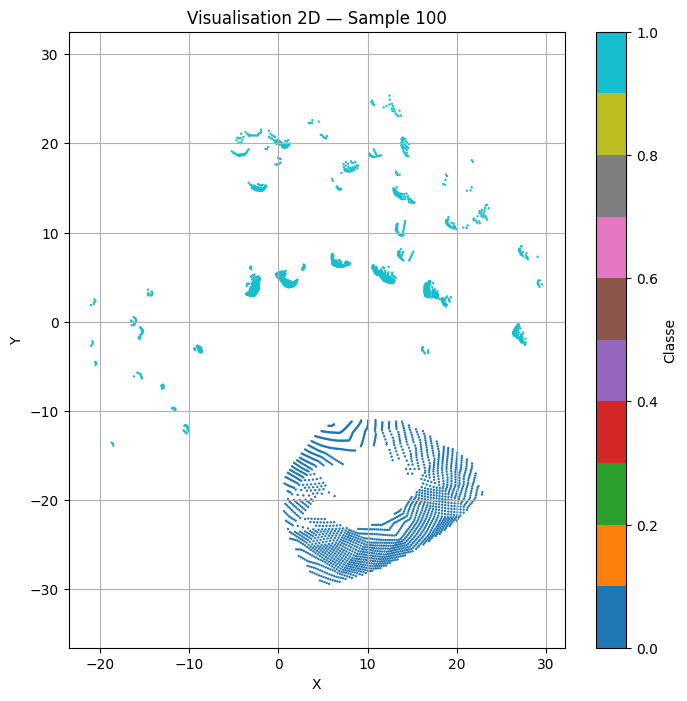

In [20]:
import matplotlib.pyplot as plt

def visualize_sample(index):
    sample = dataset[index]  # ici, pas besoin de DataLoader ou batch
    pos = sample.pos.cpu().numpy()
    labels = sample.y.cpu().numpy()

    fig = plt.figure(figsize=(8, 8))
    scatter = plt.scatter(pos[:, 0], pos[:, 1], c=labels, cmap='tab10', s=0.5)
    plt.colorbar(scatter, label='Classe')
    plt.title(f"Visualisation 2D — Sample {index}")
    plt.xlabel("X")
    plt.ylabel("Y")
    plt.axis("equal")
    plt.grid(True)
    plt.show()

visualize_sample(100)


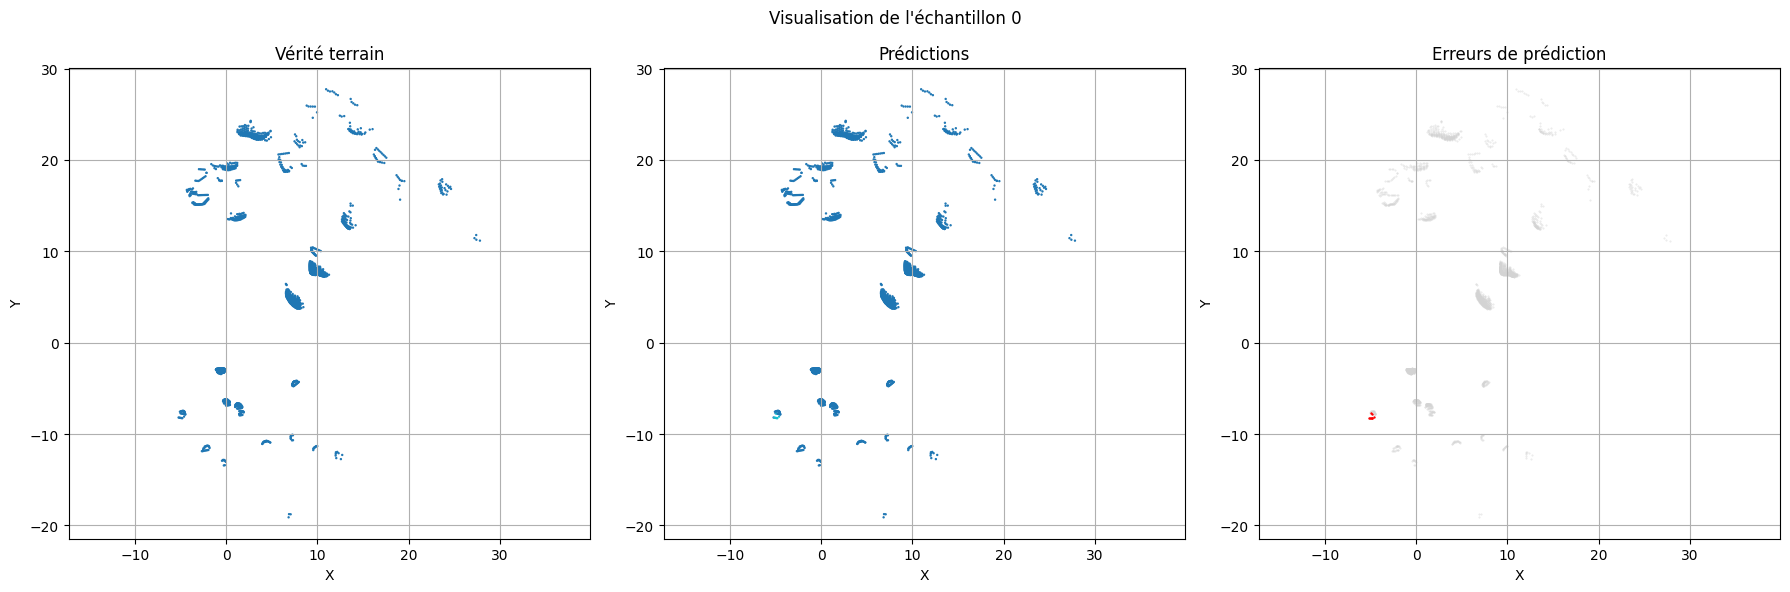

In [22]:
import matplotlib.pyplot as plt
from torch_geometric.data import Batch

def visualize_prediction(index):
    model.eval()
    sample = dataset[index].to(device)
    with torch.no_grad():
        batch = Batch.from_data_list([sample])
        pred_logits = model(batch)
        pred = pred_logits.argmax(dim=1).squeeze().cpu().numpy()

    true = sample.y.cpu().numpy()
    pos = sample.pos.cpu().numpy()

    fig, axs = plt.subplots(1, 3, figsize=(18, 6))

    axs[0].scatter(pos[:, 0], pos[:, 1], c=true, cmap='tab10', s=0.5)
    axs[0].set_title("Vérité terrain")

    axs[1].scatter(pos[:, 0], pos[:, 1], c=pred, cmap='tab10', s=0.5)
    axs[1].set_title("Prédictions")

    mask = (pred != true) & (true != -1)
    axs[2].scatter(pos[:, 0], pos[:, 1], c='lightgrey', s=0.2, alpha=0.5)
    axs[2].scatter(pos[mask, 0], pos[mask, 1], c='red', s=0.5)
    axs[2].set_title("Erreurs de prédiction")

    for ax in axs:
        ax.set_xlabel("X")
        ax.set_ylabel("Y")
        ax.axis("equal")
        ax.grid(True)

    plt.suptitle(f"Visualisation de l'échantillon {index}")
    plt.tight_layout()
    plt.show()

visualize_prediction(0)


In [23]:
import numpy as np
import matplotlib.pyplot as plt

CATEGORY_COLORS = {
    -1: "#BB469C",  # regolith
     0: "#7800C8",  # crater
   174: "#E8FA50"   # rock
}

def label_to_rgb(cat):
    hex_color = CATEGORY_COLORS.get(cat, "#BBBBBB")
    return tuple(int(hex_color.lstrip("#")[i:i+2], 16) for i in (0, 2, 4))

def project_points(points_cam, K):
    mask = points_cam[:, 2] > 0
    pts = points_cam[mask]
    if pts.shape[0] == 0:
        return np.zeros((0,2)), np.zeros(0), mask
    pts_2d = (K @ pts.T).T
    pts_2d = pts_2d[:, :2] / pts_2d[:, 2:3]
    return pts_2d, pts[:, 2], mask

# --- Calcul global du mapping id (catégorie réelle) → index utilisé
all_labels = torch.cat([data.y for data in dataset])
unique_ids = sorted(set(all_labels.tolist()))
idx_to_id = {i: cid for i, cid in enumerate(unique_ids)}

def visualize_prediction_on_image(index):
    data = dataset[index]
    lidar_points = data.pos.cpu().numpy()
    lidar_cat    = data.y.cpu().numpy()
    img          = np.load(dataset.paths[index], allow_pickle=True)["image_left"]

    # projection caméra
    points_cam = np.zeros_like(lidar_points)
    points_cam[:, 0] = lidar_points[:, 1]
    points_cam[:, 1] = lidar_points[:, 2]
    points_cam[:, 2] = lidar_points[:, 0]

    K = np.array([[680, 0, 512], [0, 680, 288], [0, 0, 1]], dtype=np.float32)
    h, w, _ = img.shape
    pts_2d, _, mask = project_points(points_cam, K)
    u = pts_2d[:, 0]
    v = pts_2d[:, 1]
    in_bounds = (u >= 0) & (u < w) & (v >= 0) & (v < h)
    final_mask = mask.copy()
    final_mask[mask] = in_bounds

    pts_2d_in = pts_2d[in_bounds]

    # prédictions
    model.eval()
    with torch.no_grad():
        pred = model(data.to(device))
        pred_idx = pred.argmax(dim=1).cpu().numpy()

    # conversion vers vraies catégories
    pred_cat = np.array([idx_to_id[int(i)] for i in pred_idx])
    pred_cat = pred_cat[final_mask]

    rgb_colors = np.array([label_to_rgb(int(l)) for l in pred_cat]) / 255.

    # affichage
    plt.figure(figsize=(12, 6))
    plt.imshow(img)
    plt.scatter(pts_2d_in[:, 0], pts_2d_in[:, 1], c=rgb_colors, s=3, alpha=0.6)
    plt.title("Projection LiDAR colorée par prédiction du modèle")
    plt.axis("off")
    plt.tight_layout()
    plt.show()


KeyboardInterrupt: 

In [21]:
# Exemple
visualize_prediction_on_image(250)

NameError: name 'visualize_prediction_on_image' is not defined